In [33]:
%matplotlib inline 
import numpy as np
import pandas as pd 
import scipy as sp
import matplotlib.pyplot as plt 
import seaborn as sns 
import colossus
sns.set_style("darkgrid")

# HMF Data

In [34]:
hmf_00= pd.read_csv("tinker_08_z_00.txt",skiprows=range(12), sep=' ',
            names=['m', 'sigma', 'ln(1/sigma)', 'n_eff', 'f(sigma)', 'dn/dm', 'dn/dlnm', 'dn/dlog10m', 'n(>m)',
                   'rho(>m)', 'rho(<m)', 'Lbox(N=1)'])
#hmf_00

In [35]:
m = hmf_00["m"]

In [36]:
m

0     1.000000e+10
1     1.122018e+10
2     1.258925e+10
3     1.412538e+10
4     1.584893e+10
          ...     
95    5.623413e+14
96    6.309573e+14
97    7.079458e+14
98    7.943282e+14
99    8.912509e+14
Name: m, Length: 100, dtype: float64

# Colossus: Generating Halo Mass Function for Different Redshift

In [37]:
from colossus.cosmology import cosmology
from colossus.lss import mass_function

cosmology.setCosmology('planck18')
mfunc_fof = mass_function.massFunction(m,z =0.0 , q_in= "M", q_out="dndlnM", mdef='vir', model = 'tinker08')


# Total Lensing Cross-section
The total lensing cross-section is the sum of number of available lens in at redshift z and its lensing cross-section of it. Therefore, from the Halo Mass function, we can calculate the comoving number density of haloes and mass distribution of haloes at certain redshift $z_{L}$. 

Recall the the lensing cross-section is defined as: 
\begin{equation}
\begin{split}
\sigma^{S}(> \mu_{0} = 10) &= 2 \pi  \theta_{E}^{2} \frac{(\mu_{0}^{2}+1)}{(\mu_{0}^{2} -1)^{2}} \\
&= \frac{8 \pi^{3} G^{2}}{c^{4}} \frac{(\mu_{0}^{2} + 1)}{(\mu_{0}^{2} -1 )^{2}} \Big( \frac{M}{r_{200}} \Big)^{2}  
\Big( \frac{d_{A}(z_{L},z_{S})}{d_{A}(Z_{s})} \Big)^{2}
\end{split}
\end{equation}

Then, the total cross-section per unit volume will be 

\begin{equation}
\sigma^{S}_{total} = \sum_{i} \frac{dn(M_{i},z)}{d \ln M_{i}} \sigma^{S}(M_{i},z) * \Delta \ln M_{i} 
\end{equation}

As the lensing and total lensing cross-section involve the maginification, in this case we assume the thershold of magnificarion is $\mu_{0} > 10$. The magnification of gravitational waves is given by its luminosity distance from distant places and the place we observed it ( in this case we choose $z_{obs}$ = 0.15). Hence, we can obtain the relation of $\mu_{GW}$ as follows:

\begin{equation}
\mu_{GW}(z)=  \Big( \frac{d_{L}(z)}{d_{L, \mu = 1(z_{obs} = 0.15)}} \Big)^{2}
\end{equation}

For instance, in order to reinterpret a source initially identified at $z \approx 0.1 $ as actually being at $z=1$ we requires
the maginification of g-waves $\mu_{GW} = 200$ ; To reinterpret sources initially identified at $z \approx 0.2$ as actually being at $z=1$ requires $\mu_{GW}$ ≃ 45.
As the total lensing cross section falls like $ \sigma_{tot} \propto \frac{1}{\mu^{4}}$, we can approximate it as follow: 

\begin{equation}
\sigma^{S}_{total} =  \frac{8 \pi^{3} G^{2}}{\mu_{GW}(z)^{2} c^{4}} \frac{(\mu_{GW}^{2}+1)}{(\mu_{GW}^{2} -1)^{2}} \sum_{i} \frac{dn(M_{i},z_{L})}{d \ln{M_{i}}} * \Delta \ln{M_{i}} \Big( \frac{M(z_{L})}{r_{200}} \Big)^{2}\Big( \frac{d_{A}(z_{L},z_{S})}{d_{A}(z_{s})} \Big)^{2}
\end{equation}

Therefore, without any calculation, we should expect that the lensing cross section suffers from a large suppresion when the maginification $\mu_{GW}$ is larger. That means we are less likely to observe gravitational waves from high redshift region as its required $\mu_{GW}$ is very big. 

\begin{equation}
\sigma^{S}_{total}(\mu_{GW},z_{S}) =  \frac{8 \pi^{3} G^{2}}{c^{4}}\frac{(\mu_{GW}(z_{S})^{2}+1)}{(\mu_{GW}(z_{S})^{2} -1)^{2}} \int^{z_{S}}_{0} \int_{\Omega_{M}} \frac{dn(M,z_{L})}{d \ln{M}} \Big( \frac{M}{r_{200}} \Big)^{2}\Big( \frac{d_{A}(z_{L},z_{S})}{d_{A}(z_{s})} \Big)^{2} d\ln{M} dV(z_{L})
\end{equation}



In [38]:
# Astropy testing total lensing cross section 
import astropy 
from astropy.constants import c, G
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70*u.km/u.s/u.Mpc, Om0=0.3)
H_0 = cosmo.H(0)
from colossus.halo import mass_so

def Hubble(z): 
    return H_0*np.sqrt(0.3*(1+z)**3 + 0.7)

#Assume Virial mass
def r_200(m,zl): 
    return (m*G/(100*Hubble(zl)**2))**(1/3)

### COLOSSUS R_200c 
def R_200c(m,zl):
    #return np.array([mass_so.M_to_R(m, i, '200c') for i in zs])
    return mass_so.M_to_R(m, zl, '200c')

# Differential Mass
def dlnm(m):
    # Change 0 into last position inside array
    dM = np.append(np.array([np.log(m[i+1])-np.log(m[i]) for i in range(0,len(m)-1)]), np.array([np.log(m[11])-np.log(m[10])]))
    return dM

# Comoving Number density of Haloes per ln(Haloes Mass)
def dndlnm(m,zl):
    mfunc_fof = mass_function.massFunction(m,z =zl , q_in= "M", q_out="dndlnM", mdef='200c', model = 'tinker08')
    return mfunc_fof



# total lensing cross secion (in dn/dlnm unit)
def total_cross_sec(m,zl,zs):
    # 2 for loops: 
    
    ### We need to add a if statement that z_{L} < z_{S}
    ### for a source in Z_{s}, the available lenses are in z_{L} < z_{S}, thus, we sum over the z_{l} from 0 to z_{S}
    # For a particular lens redshift, we sum over all the contribution of these lenses
    cross_sec = np.array([np.sum(np.asarray([(8*np.pi**3*G**2*c**-4)*dlnm(m)*dndlnm(m,i)*(m/r_200(m=m,zl=i)*cosmo.comoving_volume(i)*(cosmo.angular_diameter_distance_z1z2(i,j)/cosmo.angular_diameter_distance(j)))**2\
                       for i in zl])) for j in zs])
    return cross_sec



In [39]:
r_200(m,1)

0     0.007602
1     0.007900
2     0.008209
3     0.008530
4     0.008864
        ...   
95    0.291261
96    0.302656
97    0.314497
98    0.326800
99    0.339586
Name: m, Length: 100, dtype: float64

# Theory of Gravitational Lensing 
The total lensing cross-section is the sum of number of available lens in at redshift z and its lensing cross-section of it. Therefore, from the Halo Mass function, we can calculate the comoving number density $n(z_{L},M)$ of haloes and mass distribution of haloes at certain redshift $z_{L}$. 

Recall the the lensing cross-section is defined as: 
\begin{equation}
\begin{split}
\sigma^{S}(> \mu_{0} = 10) &= 2 \pi  \theta_{E}^{2} \frac{(\mu_{0}^{2}+1)}{(\mu_{0}^{2} -1)^{2}} \\
&= \frac{8 \pi^{3} G^{2}}{c^{4}} \frac{(\mu_{0}^{2} + 1)}{(\mu_{0}^{2} -1 )^{2}} \Big( \frac{M}{r_{200}} \Big)^{2}  
\Big( \frac{d_{A}(z_{L},z_{S})}{d_{A}(Z_{s})} \Big)^{2}
\end{split}
\end{equation}

Then, the total cross-section per unit volume will be 

\begin{equation}
\sigma^{S}_{total} = \int^{z_{S}}_{0}\int \frac{dn(M,z)}{d \ln M} \sigma^{S}(M,z) d\ln M dV_{com} dz_{L}
\end{equation}


In [40]:
### Total Cross-section: integrate all the available lenses 

def cs(m,zs): 
    ### USE R_200C instead of virial mass r_200
    ### Inner Loop: we integrate the total lens contribution in range zl \in (0,zs) for a given zs ###
    ### Outer Loop: For each source redshift zs, we want to find the total lensing cross-section at zs ###
    cross_sec = np.array([np.sum(np.asarray([(8*np.pi**3*G**2*c**-4)*dlnm(m)*dndlnm(m,i)*(m/r_200(m=m,zl=i)*cosmo.differential_comoving_volume(i)*(cosmo.angular_diameter_distance_z1z2(i,j)/cosmo.angular_diameter_distance(j)))**2\
                       for i in np.linspace(0,j,len(zs))])) for j in zs])
    
    return cross_sec 
                                   
                
                

In [41]:
# Gws source range z_{S} = 0.01 ~ 5 since z_{L} < z_{S}
zs = np.linspace(0.001,10,50)

# range of lens redshift z_{L}
#zl = np.linspace(0,10,50)

In [42]:
cross_sec = cs(m,zs)

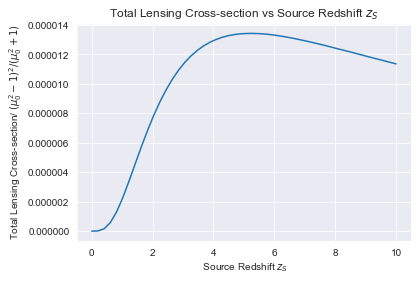

In [43]:
plt.plot(zs,cross_sec)
plt.title(r"Total Lensing Cross-section vs Source Redshift $z_{S}$ ")
plt.ylabel(r" Total Lensing Cross-section/ $(\mu_{0}^{2}-1)^{2}/(\mu_{0}^{2} + 1)$")
plt.xlabel(r" Source Redshift $z_{S}$")
plt.savefig("lensing.pdf")
#plt.yscale("log")

In [44]:
cross_sec_data = pd.DataFrame({"zs":zs, "sigma":cross_sec})

In [45]:
cross_sec_data[cross_sec_data["sigma"] == np.max(cross_sec_data["sigma"])]

,zs,sigma
26,5.306592,0.000013


In [46]:
#total_cross_sec(m,zl,zs)

### z_{L} = 0 have bug ??? ###

In [47]:
#plt.plot(zs,total_cross_sec(m,zl,zs))
#plt.yscale("log")
#plt.title(" Total Lensing Cross section vs source redshift")
#plt.savefig("lensing.pdf")

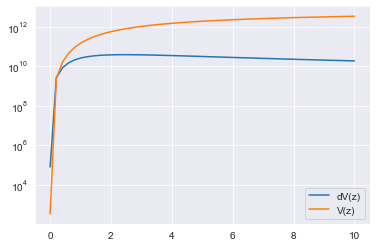

In [48]:
plt.plot(zs, cosmo.differential_comoving_volume(zs), label="dV(z)")
plt.plot(zs, cosmo.comoving_volume(zs), label="V(z)")
plt.yscale("log")
plt.legend()

# Einstein Radius 

\begin{equation}
\Sigma_{crit} = \frac{c^{2}}{4 \pi G} \frac{d_{A}(z_{S})}{d_{A}(z_{L},z_{S}) d_{A}(z_{L})}
\end{equation}

\begin{equation}
\begin{split}
\theta_{E} &= \frac{1}{2 \Sigma_{crit} d_{A}(z_{L})} \Big(\frac{M}{r_{200}} \Big) \\
           &= \frac{2 \pi G}{c^{2}} \frac{d_{A}(z_{L},z_{S})}{d_{A}(z_{S})} \frac{M}{r_{200}}
\end{split}
\end{equation}





In [49]:
# Maginification of Gravotational waves 
def mu_gw(zs):
    # zs > 0.3 by computation
    return (cosmo.luminosity_distance(zs)/cosmo.luminosity_distance(0.1))**2 

In [50]:
mu_gw(zs)

<Quantity [8.67034052e-05, 4.79397851e+00, 2.34878119e+01, 6.20069207e+01,
           1.25237361e+02, 2.17097248e+02, 3.40733836e+02, 4.98716091e+02,
           6.93185107e+02, 9.25962441e+02, 1.19862624e+03, 1.51256486e+03,
           1.86901518e+03, 2.26909057e+03, 2.71380189e+03, 3.20407340e+03,
           3.74075532e+03, 4.32463380e+03, 4.95643893e+03, 5.63685142e+03,
           6.36650814e+03, 7.14600672e+03, 7.97590957e+03, 8.85674726e+03,
           9.78902150e+03, 1.07732077e+04, 1.18097570e+04, 1.28990989e+04,
           1.40416421e+04, 1.52377768e+04, 1.64878758e+04, 1.77922958e+04,
           1.91513786e+04, 2.05654520e+04, 2.20348306e+04, 2.35598171e+04,
           2.51407027e+04, 2.67777679e+04, 2.84712829e+04, 3.02215089e+04,
           3.20286976e+04, 3.38930928e+04, 3.58149298e+04, 3.77944368e+04,
           3.98318346e+04, 4.19273373e+04, 4.40811524e+04, 4.62934815e+04,
           4.85645201e+04, 5.08944584e+04]>

In [51]:
### cross-section where mu_{GW} is not a constant, it is a function depending on z_{S}
def cs_mu(m,zs): 
    ### What is the differences of using dV and V ???? 
    ### Inner Loop: we integrate the total lens contribution in range zl \in (0,zs) for a given zs ###
    ### Outer Loop: For each source redshift zs, we want to find the total lensing cross-section at zs ###
    cross_sec = np.array([np.sum(np.asarray([(8*np.pi**3*G**2*c**-4)*dlnm(m)*((mu_gw(j)**2+1)/(mu_gw(j)**2-1)**2)*dndlnm(m,i)*(m/r_200(m=m,zl=i)*cosmo.comoving_volume(i)*(cosmo.angular_diameter_distance_z1z2(i,j)/cosmo.angular_diameter_distance(j)))**2\
                       for i in np.linspace(0,j,len(zs))])) for j in zs])
    
    return cross_sec  

In [52]:
cross_sec_mu = cs_mu(m,zs=np.linspace(0.001,0.8,50))

In [53]:
cross_sec_mu

array([7.66229457e-23, 2.01606998e-15, 1.08873143e-13, 1.30328021e-12,
       1.02283571e-11, 1.01018228e-10, 5.18600210e-08, 6.35354293e-10,
       2.83153593e-10, 2.19721798e-10, 2.04539194e-10, 2.05357051e-10,
       2.13243816e-10, 2.24643698e-10, 2.37908052e-10, 2.52094941e-10,
       2.66675547e-10, 2.81219069e-10, 2.95543718e-10, 3.09445991e-10,
       3.22835986e-10, 3.35640738e-10, 3.47859380e-10, 3.59379552e-10,
       3.70303706e-10, 3.80484265e-10, 3.90048689e-10, 3.98825894e-10,
       4.07010926e-10, 4.14601445e-10, 4.21519782e-10, 4.27775825e-10,
       4.33386869e-10, 4.38459658e-10, 4.42899065e-10, 4.46874618e-10,
       4.50281360e-10, 4.53228519e-10, 4.55652239e-10, 4.57623202e-10,
       4.59142676e-10, 4.60230419e-10, 4.60957140e-10, 4.61276656e-10,
       4.61324238e-10, 4.61025566e-10, 4.60378838e-10, 4.59564178e-10,
       4.58369103e-10, 4.56977154e-10])

In [54]:
mu_z = mu_gw(zs=np.linspace(0.001,0.8,50))

In [55]:
#mu_z

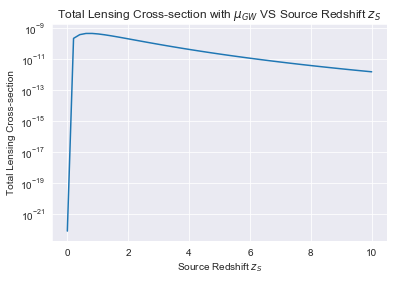

In [56]:
plt.plot(np.linspace(0.001,10,50),cs_mu(m,zs= np.linspace(0.001,10,50)))
plt.title("Total Lensing Cross-section with $\mu_{GW}$ VS Source Redshift $z_{S}$")
plt.xlabel(r"Source Redshift $z_{S}$")
plt.ylabel(r"Total Lensing Cross-section")
plt.yscale("log")

In [57]:
cross_sec_mu_data = pd.DataFrame({"zs":np.linspace(0.001,10,50), "sigma":cs_mu(m,zs= np.linspace(0.001,10,50))})

In [58]:
cross_sec_mu_data[cross_sec_mu_data["sigma"]==np.max(cross_sec_mu_data["sigma"])]

,zs,sigma
4,0.817245,4.552311e-10


Text(0.5, 0, ' Magnification $\\mu_{GW}$')

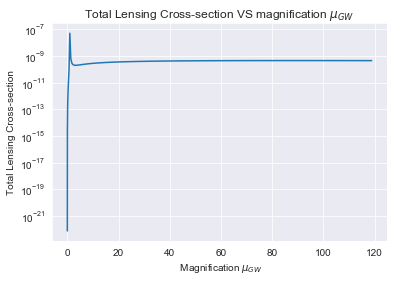

In [67]:
plt.plot(mu_z, cross_sec_mu)
plt.yscale("log")
#plt.xscale("log")
plt.title(r"Total Lensing Cross-section VS magnification $\mu_{GW}$")
plt.ylabel(r"Total Lensing Cross-section")
plt.xlabel(r" Magnification $\mu_{GW}$")


In [60]:
cs_vs_mu_data = pd.DataFrame({"mu":mu_z, "sigma":cross_sec_mu})
cs_vs_mu_data[cs_vs_mu_data["sigma"]==np.max(cs_vs_mu_data["sigma"])]

,mu,sigma
6,0.975346,5.186002e-08


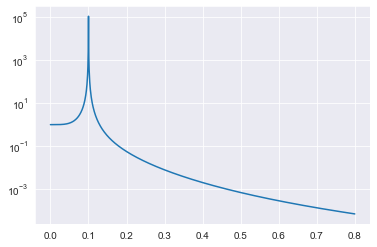

In [61]:
z = np.linspace(0,0.8,1000)
plt.plot(z, (mu_gw(z)**2+1)/(mu_gw(z)**2-1)**2)
plt.yscale("log")


In [62]:
cosmo.comoving_volume(2)*0.2/1E9

<Quantity 116.43222382 Mpc3>